# Lectura y Análisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-04-03 15:25:10.548576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743690310.665727  146644 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743690310.693987  146644 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 15:25:10.863963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carga de datos

In [2]:
file_name = "grafcan_cuesta_features.csv"
dataset_path = "../1_tratamiento_datos/processed_data/" + file_name

df = pd.read_csv(dataset_path, parse_dates=['time']).drop(columns=['artificial_value_flag', 'outlier_flag'])

In [3]:
# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_index = indices[0]
print(df.iloc[first_2025_index])

time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object


In [4]:
###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

no_normalize = ["sin_day", "cos_day", "sin_year", "cos_year"]

features = df.drop(columns=["time", *no_normalize]).astype("float32")

features.index = df["time"]

normalized_features, mean, std = normalize(features.values, first_2025_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)

for col in no_normalize:
    normalized_features[col] = df[col].astype("float32")

print(normalized_features.dtypes, normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_index].reset_index(drop=True)
val_data = normalized_features.loc[first_2025_index:].reset_index(drop=True)

print(train_data.head())
print(val_data.head())

air_temperature         float32
atmospheric_pressure    float32
relative_humidity       float32
sin_day                 float32
cos_day                 float32
sin_year                float32
cos_year                float32
dtype: object    air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.018304              1.333987           0.670254  0.000000   
1        -1.062528              1.216466           0.716861  0.258819   
2        -1.149606              1.090952           1.053583  0.500000   
3        -1.249924              0.887425           1.078569  0.707107   
4        -1.374478              0.768502           1.157604  0.866025   

    cos_day  sin_year  cos_year  
0  1.000000  0.849817  0.527078  
1  0.965926  0.850195  0.526468  
2  0.866025  0.850572  0.525858  
3  0.707107  0.850949  0.525248  
4  0.500000  0.851326  0.524637  
   air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.018304              1.333987      

In [5]:
print("mean", mean)
print("std", std)

mean [ 20.345667 977.2128    68.56473 ]
std [ 3.4997928  3.3524375 16.775301 ]


In [6]:

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST
step =12

def create_dataset(target, features, past=1, future=1, step=1):
  label_start = past
  label_end = label_start + first_2025_index
  
  y_train_full = normalized_features.iloc[label_start:label_end][target]

  x_train = []
  y_train_multi = []
  for i in range(0, len(train_data) - past - future + 1, step):
    # Create a window for x using the past period
    x_window = train_data.iloc[i:i + past][features].values
    x_train.append(x_window)
    # The corresponding y window from the target series
    y_window = y_train_full.iloc[i:i + future].values
    y_train_multi.append(y_window)
  x_train = np.array(x_train)
  y_train_multi = np.array(y_train_multi)

  # Validation data structure #
  #############################
  val_label_start = first_2025_index + past
  y_val_full = normalized_features.iloc[val_label_start:][target]

  x_val = []
  y_val_multi = []
  for i in range(0, len(val_data) - past - future + 1, step):
    x_window = val_data.iloc[i:i + past][features].values
    x_val.append(x_window)
    y_window = y_val_full.iloc[i:i + future].values
    y_val_multi.append(y_window)
  x_val = np.array(x_val)
  y_val_multi = np.array(y_val_multi)
  
  return x_train, y_train_multi, x_val, y_val_multi

sets = {}


for target in ["air_temperature", "relative_humidity", "atmospheric_pressure"]:
  features = ["sin_day", "cos_day", "sin_year", "cos_year", target]
  x_train, y_train_multi, x_val, y_val_multi = create_dataset(target, features, past, future, step)
  sets[target] = {
    "x_train": x_train,
    "y_train_multi": y_train_multi,
    "x_val": x_val,
    "y_val_multi": y_val_multi
  }


In [13]:
x_train = sets["air_temperature"]["x_train"]
y_train_multi = sets["air_temperature"]["y_train_multi"]

x_val = sets["air_temperature"]["x_val"]
y_val_multi = sets["air_temperature"]["y_val_multi"]

#############
# BATCH AND SHUFFLE
#############
BATCH_SIZE = 8
SHUFFLE = False

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_multi))
if SHUFFLE:
  train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_multi))
if SHUFFLE:
  val_dataset = val_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.batch(BATCH_SIZE)

for batch_x, batch_y in train_dataset.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy()[:2])
    print("First batch Y:", batch_y.numpy()[:2])
for batch_x, batch_y in val_dataset.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy()[:2])
    print("First batch Y:", batch_y.numpy()[:2])

First batch X: [[[ 0.0000000e+00  1.0000000e+00  8.4981710e-01  5.2707773e-01
   -1.0183043e+00]
  [ 2.5881904e-01  9.6592581e-01  8.5019493e-01  5.2646804e-01
   -1.0625280e+00]
  [ 5.0000000e-01  8.6602539e-01  8.5057235e-01  5.2585810e-01
   -1.1496063e+00]
  [ 7.0710677e-01  7.0710677e-01  8.5094929e-01  5.2524787e-01
   -1.2499236e+00]
  [ 8.6602539e-01  5.0000000e-01  8.5132581e-01  5.2463740e-01
   -1.3744781e+00]
  [ 9.6592581e-01  2.5881904e-01  8.5170186e-01  5.2402663e-01
   -1.2042398e+00]
  [ 1.0000000e+00  6.1232343e-17  8.5207754e-01  5.2341563e-01
   -1.1726109e+00]
  [ 9.6592581e-01 -2.5881904e-01  8.5245275e-01  5.2280432e-01
   -1.1653309e+00]
  [ 8.6602539e-01 -5.0000000e-01  8.5282749e-01  5.2219278e-01
   -1.0084989e+00]
  [ 7.0710677e-01 -7.0710677e-01  8.5320181e-01  5.2158093e-01
   -7.4133492e-01]
  [ 5.0000000e-01 -8.6602539e-01  8.5357571e-01  5.2096879e-01
   -4.8961487e-01]
  [ 2.5881904e-01 -9.6592581e-01  8.5394913e-01  5.2035648e-01
   -1.8352778e-01]
 

2025-04-03 15:29:46.687343: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
epochs = 750
learning_rate = 0.0015

for batch in train_dataset.take(1):
    inputs, targets = batch
    
print("Inputs shape:", inputs.shape)
print("Targets shape:", targets.shape)
    
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))

lstm_out = tf.keras.layers.LSTM(450, return_sequences=True)(inputs)
lstm_out = tf.keras.layers.LSTM(150, return_sequences=False)(lstm_out)

#lstm_out = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_out)
#lstm_out = tf.keras.layers.LSTM(128)(lstm_out)


output_units = targets.shape[1] ### * targets.shape[2]  # Flatten output shape
outputs = tf.keras.layers.Dense(output_units)(lstm_out)
# Reshape to match the target shape
#outputs = tf.keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


path_checkpoint = "model_checkpoint.weights.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    min_delta=0.00001,
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=5e-7
)


history = model.fit(
    train_dataset,
    shuffle=False,
    epochs=epochs,
    validation_data=val_dataset,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
    
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


Inputs shape: (8, 30, 5)
Targets shape: (8, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 450)        │       820,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 150)            │       360,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,181,853 (4.51 MB)

 Trainable params: 1,181,853 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/750
164/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2794
Epoch 1: val_loss improved from inf to 0.04316, saving model to model_checkpoint.weights.h5
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2761 - val_loss: 0.0432 - learning_rate: 0.0015
Epoch 2/750
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1177
Epoch 2: val_loss improved from 0.04316 to 0.04266, saving model to model_checkpoint.weights.h5
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1175 - val_loss: 0.0427 - learning_rate: 0.0015
Epoch 3/750
166/168 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0910
Epoch 3: val_loss did not improve from 0.04266
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0908 - val_loss: 0.0555 - learning_rate: 0.0015
Epoch 4/750
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0797
Epoch 4: val_loss did not improve from 0.04266
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0797 - val_loss: 0.0463 - learning_rate: 0.0015
Epoch 5/750
165/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

['temperature']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


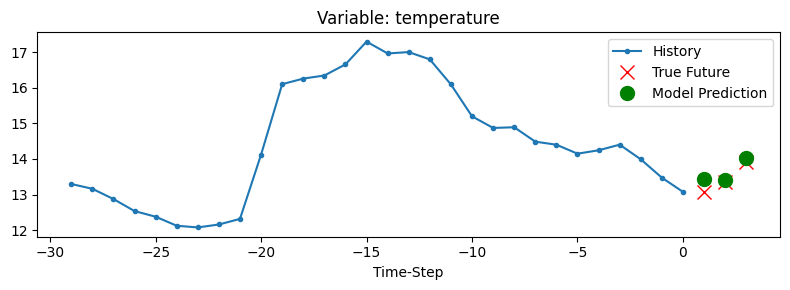

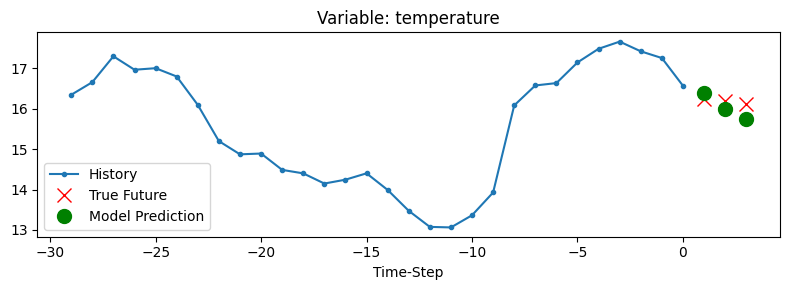

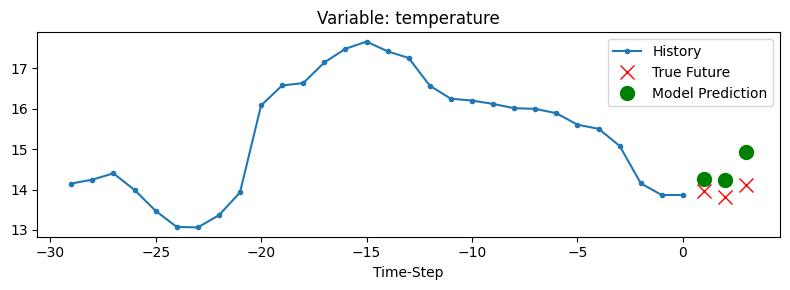

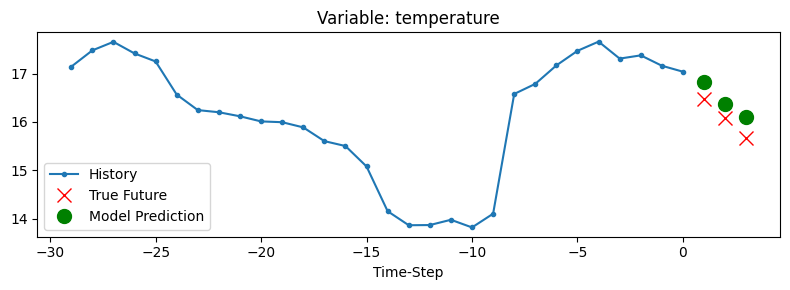

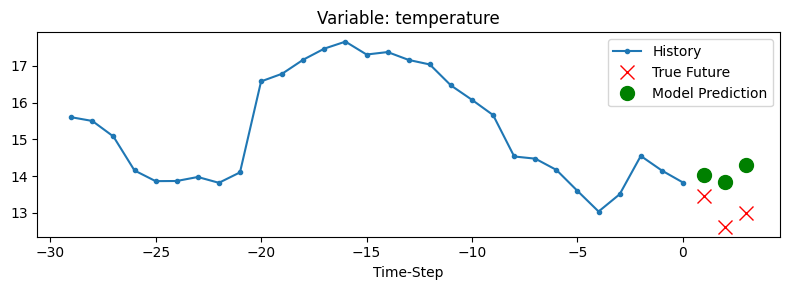

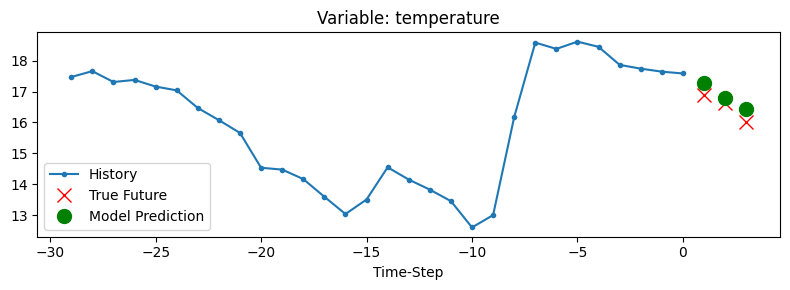

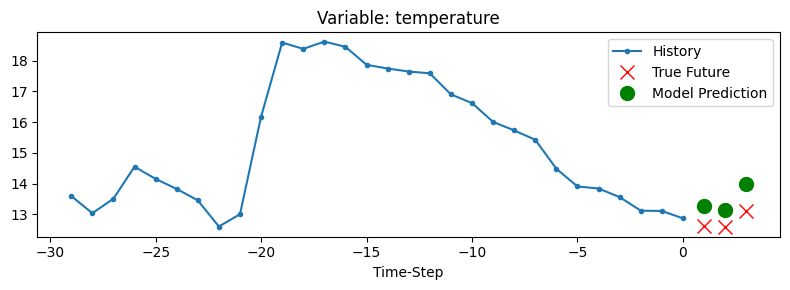

In [12]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = 1  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, 4] * std[i] + mean[i]
        true_future = plot_data[1][:] * std[i] + mean[i]
        prediction = plot_data[2][:] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = ["temperature"]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in val_dataset.take(1):
    prediction = model.predict(x)
    for i in range(7):
        show_plots_for_variables([x[i][:, :].numpy(), y[i].numpy(), prediction[i]], 0, feature_names, mean, std)    
    

In [10]:
mean = [ 20.345667, 977.2128,    68.56473 ]
std = [ 3.4997928,  3.3524375, 16.775301 ]